In [102]:
#import packages
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, t
import pandas as pd
import sys 
import os
import myfunctions #from package

In [103]:
#Problem 1

In [104]:
# Load the data
data1 = np.genfromtxt('problem1.csv', delimiter=',')
data1 = np.delete(data1, 0, axis=0)  # Remove the first row

# Fit the normal distribution
params_norm = norm.fit(data1)
mean, std = params_norm

# Fit the T-distribution
params_t = t.fit(data1)
df, loc, scale = params_t

# Run simulations
nsamples = 10000
norm_simulation = norm.rvs(loc=mean, scale=std, size=nsamples)
t_simulation = t.rvs(df=df, loc=loc, scale=scale, size=nsamples)

# Compute VaR values
var_norm = myfunctions.calculate_var(norm_simulation)
var_t = myfunctions.calculate_var(t_simulation)

print(f"Normal distribution VaR: {var_norm}")
print(f"T distribution VaR: {var_t}")

# Compute Expected Shortfall values
es_norm = myfunctions.calculate_es(norm_simulation)
es_t = myfunctions.calculate_es(t_simulation)

print(f"Normal distribution ES: {es_norm}")
print(f"T distribution ES: {es_t}")

Normal distribution VaR: 0.08190514335844643
T distribution VaR: 0.07489400347080206
Normal distribution ES: 0.10271005266061813
T distribution ES: 0.11169385270061392


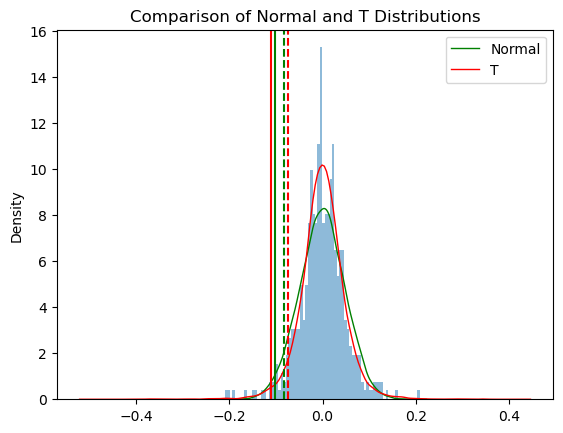

VaR of Normal distribution is 0.08190514335844643
VaR of T distribution is 0.07489400347080206
ES of Normal distribution is 0.10271005266061813
ES of T distribution is 0.11169385270061392


In [105]:
plt.hist(data1, bins=80, density=True, alpha=0.5)
sns.kdeplot(norm_simulation, color='green', linewidth=1, label='Normal')
sns.kdeplot(t_simulation, color='red', linewidth=1, label='T')

# Add vertical lines for VaR and ES (Expected Shortfall)
plt.axvline(x=-var_norm, linestyle='--', color='green')
plt.axvline(x=-es_norm, linestyle='-', color='green')
plt.axvline(x=-var_t, linestyle='--', color='red')
plt.axvline(x=-es_t, linestyle='-', color='red')

# Add legend and title
plt.legend()
plt.title('Comparison of Normal and T Distributions')

# Save and show the plot
plt.savefig('Comparison_of_Normal_and_T_Distributions.png', dpi=300)
plt.show()

# Print VaR and ES values
print(f"VaR of Normal distribution is {var_norm}")
print(f"VaR of T distribution is {var_t}")
print(f"ES of Normal distribution is {es_norm}")
print(f"ES of T distribution is {es_t}")

In [106]:
# Question 2

In [107]:
# Covariance estimation techniques Test case
df = pd.read_csv('DailyPrices.csv')
df.drop('Date',axis=1,inplace=True)
df = myfunctions.pd_return_calculate(df)
return_data = df.copy().values.T
return_data = np.matrix(np.fliplr(return_data))

weights = myfunctions.calculate_exponential_weights(return_data.shape[1], lamb=0.97)
print(weights.shape)

ew_cov = myfunctions.calculate_ewcov(return_data, lamb=0.97)
print(ew_cov.shape)

(265,)
(101, 101)


In [108]:
# Non PSD fixes for correlation matrices test case
n = 500
sigma = np.matrix(np.full((n, n), 0.9))
np.fill_diagonal(sigma, 1)
sigma[0, 1] = 0.7357
sigma[1, 0] = 0.7357

def is_psd(matrix, tol=1e-7):
    return np.all(np.linalg.eigvals(matrix) >= -tol)

print(is_psd(sigma))

near_psd_matrix = myfunctions.near_psd(sigma)
print(is_psd(near_psd_matrix))

higham_psd_matrix = myfunctions.higham_psd(sigma)
print(is_psd(higham_psd_matrix))

False
True
True


In [109]:
# Simulation Methods test case
res_d = myfunctions.direct_simulation(ew_cov)
res_pca = myfunctions.pca_simulation(ew_cov, pct_explained=0.75)
print(res_d.shape)
print(res_pca.shape)

(101, 25000)
(101, 25000)


In [110]:
# VaR calculation methods (all discussed) test case
sample_return = (return_data[0] - return_data[0].mean()).T

var_ar1 = myfunctions.ar1_var(sample_return)
var_norm = myfunctions.normal_var(sample_return)
var_ew_norm = myfunctions.ewcov_normal_var(sample_return)
var_t = myfunctions.t_var(sample_return)
var_hist = myfunctions.historic_var(sample_return)
print('var_ar1 = {}, var_norm = {}, var_ew_norm = {}, var_t = {}, var_hist = {}'.format(var_ar1, var_norm, var_ew_norm, var_t, var_hist))

<bound method SARIMAXResults.summary of <statsmodels.tsa.arima.model.ARIMAResults object at 0x0000017324B5E6D0>>
var_ar1 = 0.017485184220154, var_norm = 0.01831491552258477, var_ew_norm = 0.02698680794634882, var_t = 0.01861121274464419, var_hist = 0.01686216443331109


In [111]:
# ES calculation test case
es = myfunctions.calculate_es(sample_return)
print(es)

0.022554299416382564


In [112]:
#Question 3

In [113]:
# Load prices and portfolio data
prices = pd.read_csv("DailyPrices.csv", parse_dates=[0], index_col=0)
portfolios = pd.read_csv("portfolio.csv")

# Compute returns
returns = myfunctions.pd_return_calculate(prices)

# Summarize portfolio holdings
aggregate_holdings = portfolios.groupby('Stock').sum('Holding')
aggregate_holdings['Portfolio'] = 'Total'
aggregate_holdings.reset_index(inplace=True)

# Combine original and total portfolios
portfolios = portfolios.append(aggregate_holdings)

C:\Users\11692\AppData\Local\Temp\ipykernel_12324\1787989012.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  portfolios = portfolios.append(aggregate_holdings)


In [114]:
t_params = {}
historical_data = []
simulated_data = []

for column in returns.columns:
    individual_returns = returns[column]
    
    # Adjust the returns to a mean of zero as per the question
    individual_returns -= individual_returns.mean()
    
    # Append to historical data list
    historical_data.append(individual_returns)
    
    # Fit generalized t-distribution using MLE method
    fitted_params = t.fit(individual_returns, method="MLE")
    degrees_freedom, location, scale_factor = fitted_params
    
    # Store parameters in a dictionary
    t_params[column] = [degrees_freedom, location, scale_factor]
    
    # Perform simulation
    simulated_data.append(t(degrees_freedom, location, scale_factor).rvs(10000))

# Convert lists to NumPy arrays
historical_data = np.array(historical_data)
simulated_data = np.array(simulated_data)

In [115]:
# create pandas dataframe for the returns
historical_returns = pd.DataFrame(columns=returns.columns, data=historical_data.T)
simulated_returns = pd.DataFrame(columns=returns.columns, data=simulated_data.T)

In [116]:
# for historical data
# Initialize DataFrame for current prices
current_prices = pd.DataFrame({"Price": prices.iloc[-1]})

# Loop through portfolios grouped by 'Portfolio'
for portfolio_name, specific_portfolio in portfolios.groupby('Portfolio'):
    
    # Set index and join with current prices
    specific_portfolio = specific_portfolio.set_index('Stock')
    specific_portfolio = specific_portfolio.join(current_prices.loc[specific_portfolio.index])
    
    # Calculate historical returns for the portfolio
    hist_ret = historical_returns[specific_portfolio.index]
    simulated_price_changes = hist_ret * specific_portfolio['Price'].T
    simulated_value_changes = simulated_price_changes @ specific_portfolio['Holding']
    
    # Calculate historical VaR and ES
    historical_var = myfunctions.calculate_var(simulated_value_changes)
    historical_es = myfunctions.calculate_es(simulated_value_changes)
    
    # Output the results
    print(f"Portfolio {portfolio_name} VaR: {historical_var}")
    print(f"Portfolio {portfolio_name} ES: {historical_es}")
    print()

Portfolio A VaR: 18242.436493048866
Portfolio A ES: 25436.032975374277

Portfolio B VaR: 11337.063397132808
Portfolio B ES: 14528.193412533596

Portfolio C VaR: 23752.39753743753
Portfolio C ES: 31623.034028716083

Portfolio Total VaR: 50682.26744043997
Portfolio Total ES: 68296.60420860404



In [117]:
# for simulated data based on t distribution
# Loop over portfolios, grouped by 'Portfolio'
for portfolio_name, specific_portfolio in portfolios.groupby('Portfolio'):
    
    # Set index to 'Stock' and join with current_prices
    specific_portfolio.set_index('Stock', inplace=True)
    specific_portfolio = specific_portfolio.join(current_prices.loc[specific_portfolio.index])
    
    # Calculate simulated returns for the portfolio based on t-distribution
    t_simulated_returns = simulated_returns[specific_portfolio.index]
    simulated_price_changes = t_simulated_returns * specific_portfolio['Price'].T
    simulated_value_changes = simulated_price_changes @ specific_portfolio['Holding']
    
    # Calculate VaR and ES for the simulated data
    simulated_var = myfunctions.calculate_var(simulated_value_changes)
    simulated_es = myfunctions.calculate_es(simulated_value_changes)
    
    # Output results
    print(f"Portfolio {portfolio_name} VaR: {simulated_var}")
    print(f"Portfolio {portfolio_name} ES: {simulated_es}")
    print()

Portfolio A VaR: 8000.36326065293
Portfolio A ES: 10518.70265109013

Portfolio B VaR: 4095.6019921545076
Portfolio B ES: 5340.304954325662

Portfolio C VaR: 15089.878608526215
Portfolio C ES: 19562.391828522046

Portfolio Total VaR: 18114.471186482766
Portfolio Total ES: 22925.84759033198

